In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load dataset

In [3]:

df = pd.read_csv("D:\\Test\\processed_dataset.csv")

# Combine year, month, and day to create a datetime column

In [4]:

df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])

# Fill missing values

In [5]:

df.ffill(inplace=True)

# Handle NaNs in prev_day_demand

In [6]:

df["prev_day_demand"].fillna(df["prev_day_demand"].mean(), inplace=True)

C:\Users\Vandh\AppData\Local\Temp\ipykernel_11652\647230377.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["prev_day_demand"].fillna(df["prev_day_demand"].mean(), inplace=True)


# OneHotEncode categorical features

In [7]:

ohe_Encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas')

In [8]:
categorical_cols = ['rainfall_category', 'solar_category', 'season', 'day_of_week']
encoded_df = ohe_Encoder.fit_transform(df[categorical_cols])

In [9]:
# Concatenate encoded features and drop originals
df = pd.concat([df, encoded_df], axis=1).drop(columns=categorical_cols)

In [10]:

df = df.rename(columns={"demand": "y"})

In [11]:
# features for model training
features = [
    "min_temperature", "max_temperature", "solar_exposure", "RRP", 
    "is_weekend", "prev_day_demand"
] + list(encoded_df.columns)  




# Prophet Model WITHOUT Regressors

In [12]:


model_basic = Prophet()
model_basic.fit(df[["ds", "y"]])

17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Future dates
future_basic = model_basic.make_future_dataframe(periods=30)

In [14]:
# Predict
forecast_basic = model_basic.predict(future_basic)

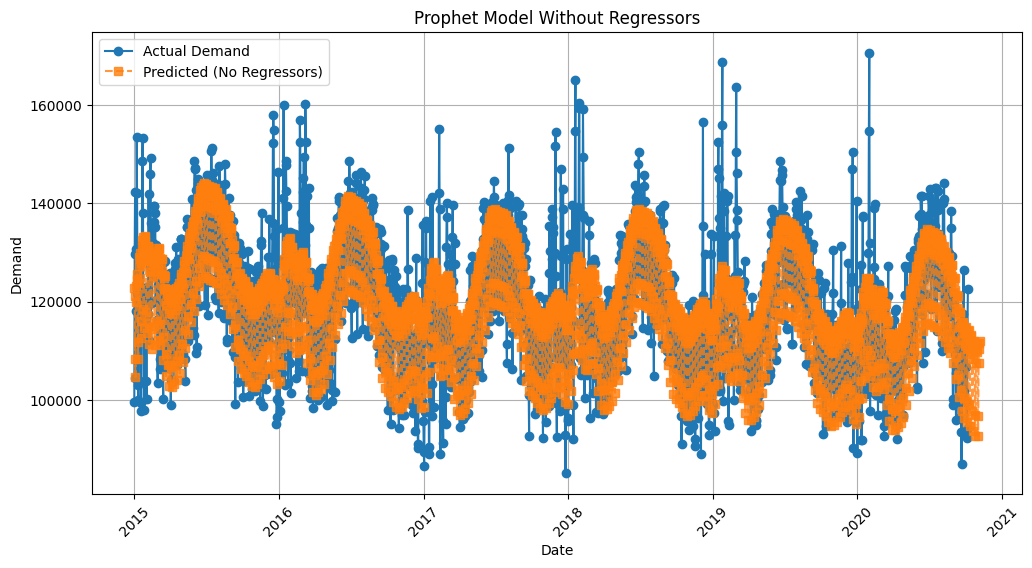

In [15]:
# Prophet model WITHOUT regressors
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Actual Demand", marker='o', linestyle="-")
plt.plot(forecast_basic["ds"], forecast_basic["yhat"], label="Predicted (No Regressors)", marker='s', linestyle="--",  alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Prophet Model Without Regressors")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [16]:

#Prophet Model WITH Regressors
model = Prophet(changepoint_prior_scale=0.5)
model.add_country_holidays(country_name='AU')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)



In [17]:
# Add all regressors
for feature in features:
    model.add_regressor(feature)
    

In [18]:
model.fit(df[["ds", "y"] + features])


17:27:07 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Future dates
future = model.make_future_dataframe(periods=400)

In [20]:
# Fill feature values
for feature in features:
    future[feature] = df[feature].iloc[-1]

In [21]:
# Predict
forecast = model.predict(future)

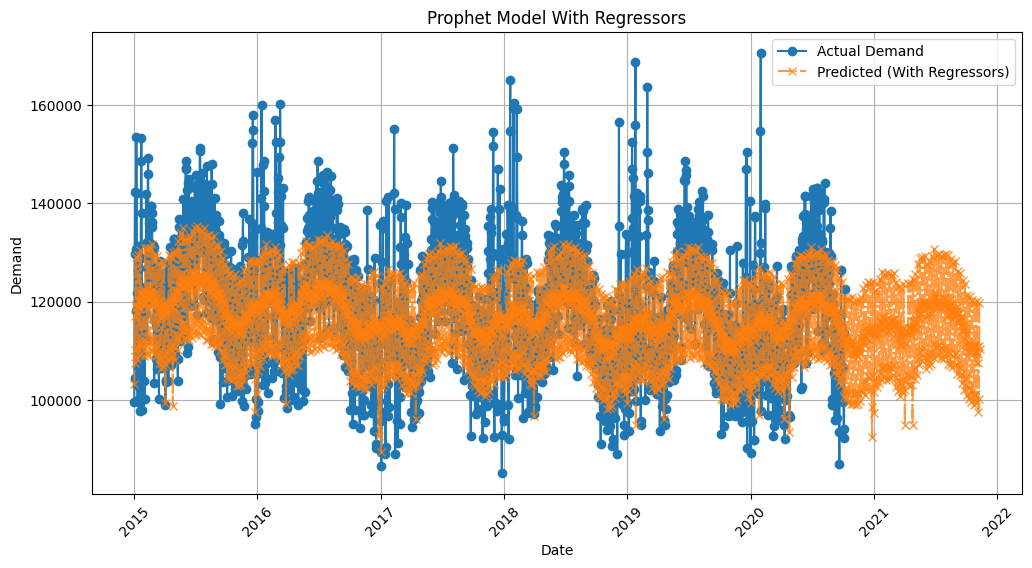

In [22]:
# Plot Prophet model WITH regressors
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Actual Demand", marker='o', linestyle="-")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted (With Regressors)", marker='x', linestyle="-.", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Prophet Model With Regressors")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get only the dates that exist in the actual dataset for evaluation
actual = df[["ds", "y"]]
predicted = forecast[["ds", "yhat"]]

# Merge actual and predicted values based on date
merged_df = actual.merge(predicted, on="ds", how="inner")

# Calculate error metrics
mae = mean_absolute_error(merged_df["y"], merged_df["yhat"])
rmse = np.sqrt(mean_squared_error(merged_df["y"], merged_df["yhat"]))
mape = np.mean(np.abs((merged_df["y"] - merged_df["yhat"]) / merged_df["y"])) * 100

# Print the results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



MAE: 8897.52
RMSE: 11625.90
MAPE: 7.15%


In [24]:
# Extend forecast for 1 year (365 days)
future = model.make_future_dataframe(periods=5200)

# Fill future dataframe with last known feature values
for feature in features:
    future[feature] = df[feature].iloc[-1]  # Use last available feature values

# Make predictions
forecast = model.predict(future)


In [25]:
target_date = pd.Timestamp("2025-12-31") 
demand_2022_end = forecast.loc[forecast["ds"] == target_date, "yhat"]


if not demand_2022_end.empty:
    print(f"Predicted Energy Demand on {target_date.date()}: {demand_2022_end.values[0]:,.2f}")
else:
    print(f"No forecasted value found for {target_date.date()}. Try extending the forecast period.")


Predicted Energy Demand on 2025-12-31: 112,273.72


In [26]:
forecast_2022 = forecast[(forecast["ds"] >= "2022-01-01") & (forecast["ds"] <= "2022-12-31")]


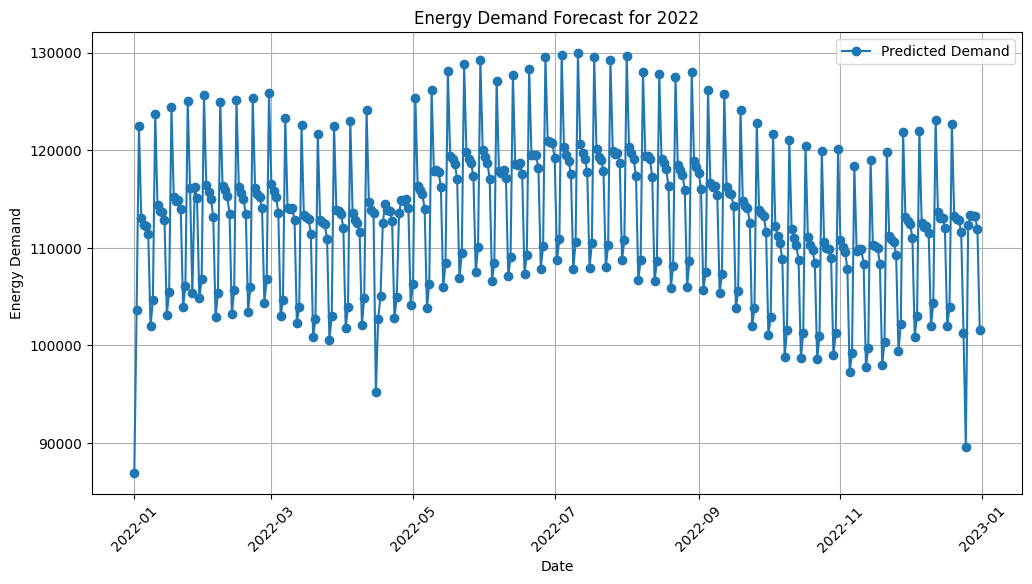

In [27]:
plt.figure(figsize=(12, 6))

# Plot actual demand
df_2022 = df[(df["ds"] >= "2022-01-01") & (df["ds"] <= "2022-12-31")]
if not df_2022.empty:
    plt.plot(df_2022["ds"], df_2022["y"], label="Actual Demand", marker="o", linestyle="-")

# Plot predicted demand
plt.plot(forecast_2022["ds"], forecast_2022["yhat"], label="Predicted Demand", marker="o", linestyle="-")

plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.title("Energy Demand Forecast for 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

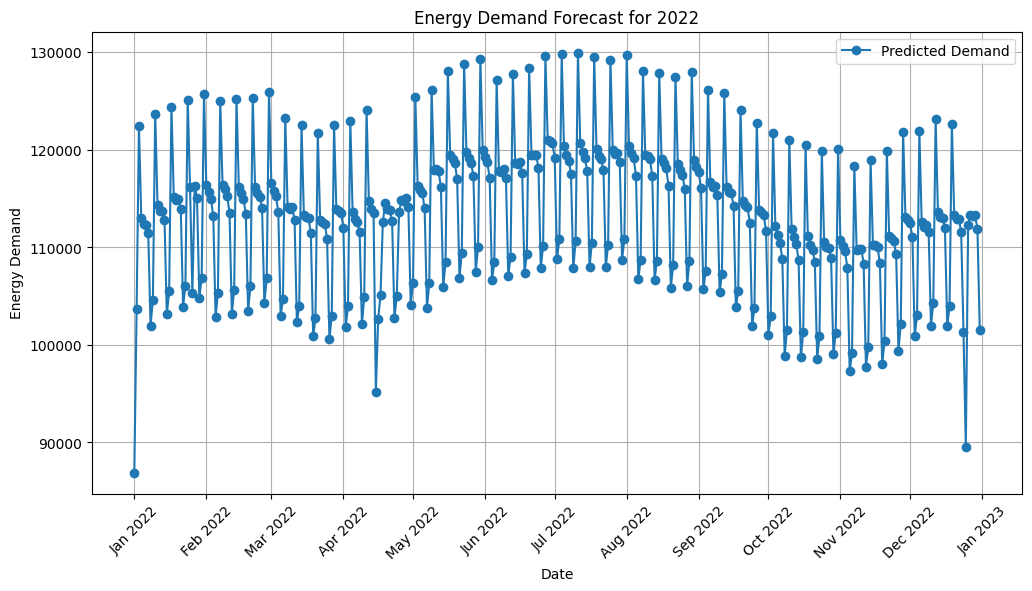

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming you have already defined df_2022 and forecast_2022 DataFrames

plt.figure(figsize=(12, 6))

# Plot actual demand
df_2022 = df[(df["ds"] >= "2022-01-01") & (df["ds"] <= "2022-12-31")]
if not df_2022.empty:
    plt.plot(df_2022["ds"], df_2022["y"], label="Actual Demand", marker="o", linestyle="-")

# Plot predicted demand
plt.plot(forecast_2022["ds"], forecast_2022["yhat"], label="Predicted Demand", marker="o", linestyle="-")

# Customize the x-axis for monthly ticks
plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.title("Energy Demand Forecast for 2022")
plt.legend()

# Set x-axis to show ticks for each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Locator for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format to show Month-Year (e.g., Jan 2022)

# Rotate date labels for readability
plt.xticks(rotation=45)

plt.grid(True)
plt.show()


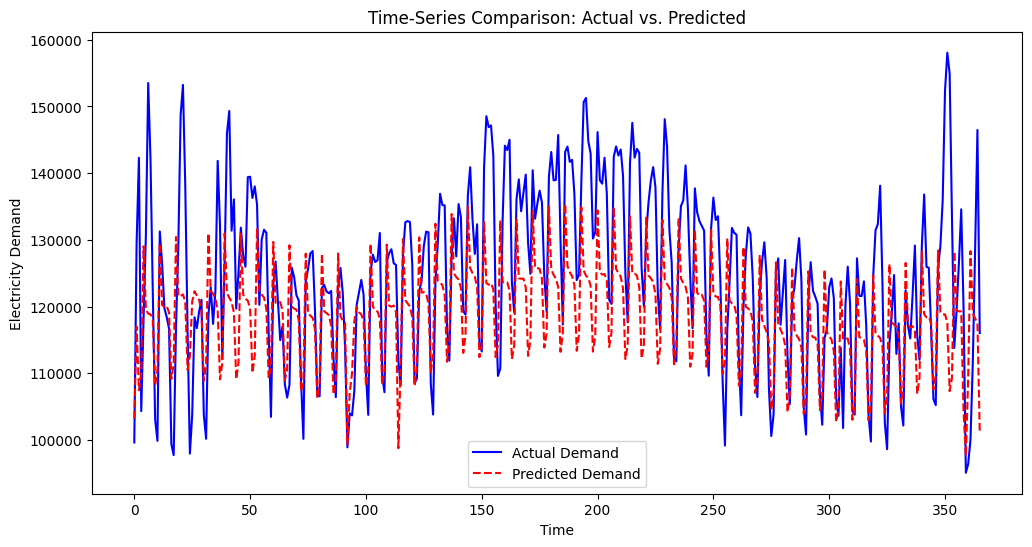

In [29]:
import matplotlib.dates as mdates

# Get start and end date from user
start_date ="2015-01-01"        #input("Enter start date (YYYY-MM-DD): ")
end_date ="2016-01-01"        #input("Enter end date (YYYY-MM-DD): ")

# Convert to datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter actual and predicted data based on user input
actual_filtered = df[(df["ds"] >= start_date) & (df["ds"] <= end_date)]
predicted_filtered = forecast[(forecast["ds"] >= start_date) & (forecast["ds"] <= end_date)]

plt.figure(figsize=(12, 6))

# Plot actual demand
if not actual_filtered.empty:
    plt.plot(actual_filtered["y"].values, label="Actual Demand", color='blue')

# Plot predicted demand
if not predicted_filtered.empty:
    plt.plot(predicted_filtered["yhat"].values, label="Predicted Demand", color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Electricity Demand")
plt.title("Time-Series Comparison: Actual vs. Predicted")
plt.legend()
plt.show()
